<a href="https://colab.research.google.com/github/FR-Schwartz/IDS705_Team10/blob/main/source/explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
drive.mount('/content/MyDrive/')
os.chdir('/content/MyDrive/MyDrive/IDS705_Final')

Mounted at /content/MyDrive/


In [3]:
# Run this code to unzip the data file
# import zipfile
# with zipfile.ZipFile("RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021.zip", 'r') as zip_ref:
#     zip_ref.extractall("Data/Train")

In [119]:
# Run this code to unzip the data file
import zipfile
with zipfile.ZipFile("Data/RSNA_ASNR_MICCAI_BraTS2021_ValidationData.zip", 'r') as zip_ref:
    zip_ref.extractall("Data")

In [116]:
#Change subfolder id to checkout different images
subfolders = os.listdir("Data/Train")
print("Number of subfolders:", len(subfolders))
subfolder_id = 500
subfolder_name = subfolders[subfolder_id]
img1 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1.nii.gz') #file_format - nifti
img2 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t2.nii.gz') #file_format - nifti2
imgce = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1ce.nii.gz') #file_format - ce
imgseg = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_seg.nii.gz') #file_format - seg
imgflair = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_flair.nii.gz') #file_format - flair
print("Name of subfolder selected:" , subfolder_name)

Number of subfolders: 1251
Name of subfolder selected: BraTS2021_01167


Shapes of images

In [117]:
print(img1.shape)
print(img2.shape)
print(imgce.shape)
print(imgseg.shape)
print(imgflair.shape)

(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)


Plot all images for a selected slice number

Text(0.5, 1.0, 'flair')

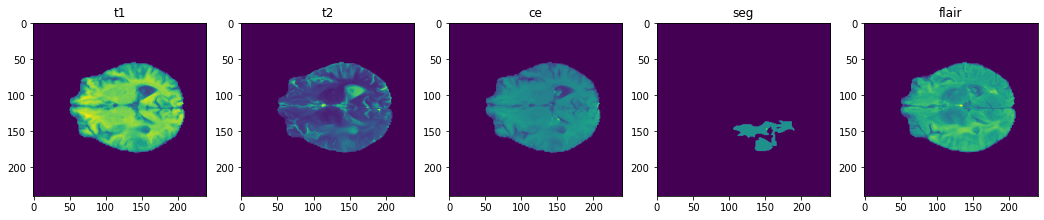

In [118]:
slice_no = 70
fig,axs = plt.subplots(1,5,figsize=(18,5))
axs[0].imshow(img1.dataobj[:,:,slice_no])
axs[1].imshow(img2.dataobj[:,:,slice_no])
axs[2].imshow(imgce.dataobj[:,:,slice_no])
axs[3].imshow(imgseg.dataobj[:,:,slice_no])
axs[4].imshow(imgflair.dataobj[:,:,slice_no])
axs[0].set_title("t1")
axs[1].set_title("t2")
axs[2].set_title("ce")
axs[3].set_title("seg")
axs[4].set_title("flair")

In [115]:
np.unique(imgseg.dataobj[150,150,70])

array([2], dtype=uint16)

In [74]:
#A starting point for how out Tensorflow model will look like
def gen_model():
    input_layer = tf.keras.layers.Input(shape=(240,240,155,1)) 
    x = tf.keras.layers.Conv3D(4, 5, strides=(2,2,2), activation='relu', padding='same')(input_layer) #120, 120, 78
    x = tf.keras.layers.Conv3D(8, 5, strides=(2,2,2), activation='relu', padding='same')(x) #60, 60, 39
    x = tf.keras.layers.Conv3D(16, 5, strides=(2,2,2), activation='relu', padding='same')(x) #30, 30, 20
    x = tf.keras.layers.Conv3D(32, 3, strides=(2,2,2), activation='relu', padding='same')(x) #15, 15, 10
    x = tf.keras.layers.Conv3D(64, 3, strides=(2,2,2), activation='relu', padding='same')(x) #8, 8, 5
    x = tf.keras.layers.Conv3D(128, 3, strides=(2,2,2), activation='relu', padding='same')(x) #4, 4, 3 
    x = tf.keras.layers.Conv3D(256, 2, strides=(2,2,2), activation='relu', padding='same')(x) #2, 2, 2   This is the bottom of the "U"
    x = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2,2,2), activation='relu', padding='same')(x) #4, 4, 4
    x = x[:,:,:,0:3,:] #4, 4, 3
    x = tf.keras.layers.Conv3DTranspose(64, 3, strides=(2,2,2), activation='relu', padding='same')(x) #8, 8, 6
    x = x[:,:,:,0:5,:] #8, 8, 5
    x = tf.keras.layers.Conv3DTranspose(64, 3, strides=(2,2,2), activation='relu', padding='same')(x) #16, 16, 12
    x = x[:,0:15,0:15,0:10,:] #15, 15, 10
    x = tf.keras.layers.Conv3DTranspose(64, 3, strides=(2,2,2), activation='relu', padding='same')(x) #16, 16, 12
    x = x[:,0:15,0:15,0:10,:] #15, 15, 10

    full_model = tf.keras.Model(inputs=input_layer, outputs=x)
    return full_model

model = gen_model()
model.summary()
batch_size = 16
n_epochs = 15
lr = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy',metrics=['acc'])

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 240, 240, 155, 1  0         
                             )]                                  
                                                                 
 conv3d_86 (Conv3D)          (None, 120, 120, 78, 4)   504       
                                                                 
 conv3d_87 (Conv3D)          (None, 60, 60, 39, 8)     4008      
                                                                 
 conv3d_88 (Conv3D)          (None, 30, 30, 20, 16)    16016     
                                                                 
 conv3d_89 (Conv3D)          (None, 15, 15, 10, 32)    13856     
                                                                 
 conv3d_90 (Conv3D)          (None, 8, 8, 5, 64)       55360     
                                                          

In [75]:
model(np.array(img1.dataobj).reshape(1,240,240,155,1)).shape

TensorShape([1, 15, 15, 10, 64])